<a href="https://colab.research.google.com/github/Ailton3112/glp/blob/main/Experimento_03_Predicao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REVGAS Prediction V 002a
 
* Sources
  - [Using machine learning to predict the next purchase date for an individual retail customer](http://www.scielo.org.za/scielo.php?script=sci_arttext&pid=S2224-78902020000300008)
  - [Predicting Next Purchase Day](https://towardsdatascience.com/predicting-next-purchase-day-15fae5548027)
  - [Using Machine Learning to Predict Customers’ Next Purchase Day](https://towardsdatascience.com/using-machine-learning-to-predict-customers-next-purchase-day-7895ad49b4db)

Tarefas FAZENDOO...

[feito] Calcular o desvio padrao e Calcular a media da lastorder pra cada modelo

[feito] Todos os clientes

[feito] Media em x meses com desvio padrao?

[feito] Tempo Médio por estado

LSTM simples

X - últimos pedidos de cliente.
Fazer Retirar dados inferiores a <10 dias

Analisando...
Informer https://github.com/Nixtla/neuralforecast

In [ ]:
import pandas
import numpy
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [ ]:
# from google.colab import drive, files
# # loaded_files = files.upload()
# drive.mount('/content/drive')

## Pré-processamento

In [ ]:
#dataset_path = 'C:\\Users\\aplne\\Documents\\Cópia de produtos_clientes.csv'
#dataset= pandas.read_csv(dataset_path)

#dataset_path = '/Users/ailtonrodrigues/Desktop/REVGAS/input/produtos_clientes.csv'
#dataset_ori = pandas.read_csv(dataset_path)

dataset_path = '/Users/ailtonrodrigues/Desktop/REVGAS/input/dados_vendas.csv'
dataset_ori = pandas.read_csv(dataset_path)

##GDrive
#dataset_ori = pd.read_csv('/content/drive/MyDrive/REVGAS/dados/produtos_clientes.csv',delimiter = ',',low_memory=False)


In [ ]:
dataset_ori.shape

(2033321, 10)

In [ ]:
dataset_ori.head()

,sale_id,client_id,date,name_product,quantity_product,value_product,total,payments,city,state_federation
0,151053,29299,2013-01-24 21:50:36,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí
1,151052,29298,2013-01-24 21:50:42,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí
2,151051,29297,2013-01-24 21:50:49,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí
3,151050,29296,2013-01-24 21:51:00,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí
4,151049,29295,2013-01-24 21:51:10,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí


In [ ]:
dataset_ori['client_id']        = pandas.to_numeric(dataset_ori['client_id'])
dataset_ori['quantity_product'] = pandas.to_numeric(dataset_ori['quantity_product'], errors='coerce')
dataset_ori['name_product']     = dataset_ori['name_product'].astype('category')
dataset_ori['value_product']    = pandas.to_numeric(dataset_ori['value_product'], errors='coerce')
dataset_ori['payments']         = dataset_ori['payments'].astype('category')
dataset_ori['total']            = dataset_ori['total'].astype('float32')
dataset_ori['date']             = dataset_ori['date'].astype('datetime64')
dataset_ori['city']             = dataset_ori['city'].astype('category')
dataset_ori['state_federation'] = dataset_ori['state_federation'].astype('category')

In [ ]:
#dataset = dataset_ori[(dataset_ori['state']=="Piauí") & (dataset_ori['product'] =='GLP 13KG')]

dataset = dataset_ori.query("(state_federation=='Piauí') & (quantity_product<=2) & (name_product=='GLP 13KG')").reset_index(drop=True)


In [ ]:
dataset.shape

(584486, 10)

In [ ]:
dataset.head()

,sale_id,client_id,date,name_product,quantity_product,value_product,total,payments,city,state_federation
0,151053,29299,2013-01-24 21:50:36,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí
1,151052,29298,2013-01-24 21:50:42,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí
2,151051,29297,2013-01-24 21:50:49,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí
3,151050,29296,2013-01-24 21:51:00,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí
4,151049,29295,2013-01-24 21:51:10,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí


In [ ]:
dataset.describe()

,sale_id,client_id,quantity_product,value_product,total
count,5.844860e+05,5.844860e+05,584486.000000,584486.000000,584486.000000
mean,1.178671e+06,1.281240e+05,1.086758,71.740838,77.852661
std,9.130596e+05,1.773451e+05,0.281481,18.075160,27.586374
min,1.510460e+05,2.929300e+04,1.000000,1.000000,1.000000
25%,4.941462e+05,4.652200e+04,1.000000,60.000000,60.000000
50%,8.502555e+05,6.420900e+04,1.000000,70.000000,72.000000
75%,1.595610e+06,1.332450e+05,1.000000,80.000000,85.000000
max,3.809991e+06,1.243195e+06,2.000000,950.000000,950.000000


In [ ]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584486 entries, 0 to 584485
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   sale_id           584486 non-null  int64         
 1   client_id         584486 non-null  int64         
 2   date              584486 non-null  datetime64[ns]
 3   name_product      584486 non-null  category      
 4   quantity_product  584486 non-null  int64         
 5   value_product     584486 non-null  float64       
 6   total             584486 non-null  float32       
 7   payments          584486 non-null  category      
 8   city              584486 non-null  category      
 9   state_federation  584486 non-null  category      
dtypes: category(4), datetime64[ns](1), float32(1), float64(1), int64(3)
memory usage: 27.9 MB


In [ ]:
dataset.isnull().sum()

sale_id             0
client_id           0
date                0
name_product        0
quantity_product    0
value_product       0
total               0
payments            0
city                0
state_federation    0
dtype: int64

In [ ]:
 dataset['quantity_product'] = dataset['quantity_product'].fillna(1)
 dataset['value_product']    = (dataset['value_product'].fillna(dataset['value_product'].mean()))

In [ ]:
dataset.sort_values(['client_id', 'date'], ascending=True, inplace=True)

In [ ]:
dataset.head()

,sale_id,client_id,date,name_product,quantity_product,value_product,total,payments,city,state_federation
2347,153398,29293,2013-04-09 22:17:37,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí
4515,155595,29293,2013-05-18 23:12:27,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí
6558,157615,29293,2013-06-25 22:21:47,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí
8931,160001,29293,2013-08-11 21:51:12,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí
12197,163353,29293,2013-10-17 22:57:38,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí


In [ ]:
# last_order = numpy.zeros(shape=(dataset.shape[0],))
# client = -1
# last_date = None
# count = 0
# for i, r in dataset.iterrows():
#   if r['client_id'] == client:
#     last_order[count] = (r['date'] - last_date) / numpy.timedelta64(1, 'D')
#   else:
#     client = r['client_id']
#   last_date = r['date']
#   count += 1
# dataset['last_order'] = last_order

In [ ]:
dataset['InvoiceDay']      = dataset['date'].dt.date
dataset['PrevInvoiceDate'] = dataset.groupby('client_id')['InvoiceDay'].shift(1)
dataset['DayDiff']         = (dataset['InvoiceDay'] - dataset['PrevInvoiceDate']).dt.days
dataset['DayDiff']         = dataset['DayDiff'].fillna(0)
dataset['PrevInvoiceDate'] = dataset['PrevInvoiceDate'].fillna(0)


In [ ]:
dataset['DayDiff'] = pandas.to_numeric(dataset['DayDiff'], errors='coerce')

dataset = dataset[(dataset != 0).all(1)]

In [ ]:
dataset.head()

,sale_id,client_id,date,name_product,quantity_product,value_product,total,payments,city,state_federation,InvoiceDay,PrevInvoiceDate,DayDiff
4515,155595,29293,2013-05-18 23:12:27,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí,2013-05-18,2013-04-09,39.0
6558,157615,29293,2013-06-25 22:21:47,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí,2013-06-25,2013-05-18,38.0
8931,160001,29293,2013-08-11 21:51:12,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí,2013-08-11,2013-06-25,47.0
12197,163353,29293,2013-10-17 22:57:38,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí,2013-10-17,2013-08-11,67.0
14345,161757,29293,2013-12-03 20:31:04,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí,2013-12-03,2013-10-17,47.0


In [ ]:
dataset.shape

(460446, 13)

In [ ]:
dataset.head()

,sale_id,client_id,date,name_product,quantity_product,value_product,total,payments,city,state_federation,InvoiceDay,PrevInvoiceDate,DayDiff
4515,155595,29293,2013-05-18 23:12:27,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí,2013-05-18,2013-04-09,39.0
6558,157615,29293,2013-06-25 22:21:47,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí,2013-06-25,2013-05-18,38.0
8931,160001,29293,2013-08-11 21:51:12,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí,2013-08-11,2013-06-25,47.0
12197,163353,29293,2013-10-17 22:57:38,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí,2013-10-17,2013-08-11,67.0
14345,161757,29293,2013-12-03 20:31:04,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí,2013-12-03,2013-10-17,47.0


In [ ]:
# def filtra_dst(state):
#     dataset = dataset_ori.query("(state_federation==@state) & (quantity_product<=2) & (name_product=='GLP 13KG')").reset_index(drop=True)
#     dataset['InvoiceDay']      = dataset['date'].dt.date
#     dataset['PrevInvoiceDate'] = dataset.groupby('client_id')['InvoiceDay'].shift(1)
#     dataset['DayDiff']         = (dataset['InvoiceDay'] - dataset['PrevInvoiceDate']).dt.days
#     dataset['DayDiff']         = dataset['DayDiff'].fillna(0)
#     dataset['PrevInvoiceDate'] = dataset['PrevInvoiceDate'].fillna(0)
#     dataset['DayDiff'] = pandas.to_numeric(dataset['DayDiff'], errors='coerce')
#     dataset = dataset[(dataset != 0).all(1)]
#     return dataset

In [ ]:
# estados = []
# for estados_l in dataset_ori['state_federation'].unique():
#   estados.append(estados_l)

In [ ]:
# estados

In [ ]:
# num = len(estados)
# num

In [ ]:
# state = 'Piauí'
# dataset= filtra_dst(state)
# dataset.head()

##GRUPO 1 <= 10 (dias entre pedidos)

In [ ]:
df_G1 = dataset.query("DayDiff<=10").reset_index(drop=True)
df_G1.sort_values(['client_id', 'date'], ascending=True, inplace=True)


In [ ]:
df_G1.head()

,sale_id,client_id,date,name_product,quantity_product,value_product,total,payments,city,state_federation,InvoiceDay,PrevInvoiceDate,DayDiff
0,320550,29293,2015-09-26 19:57:00,GLP 13KG,1,50.0,50.0,Dinheiro,Teresina,Piauí,2015-09-26,2015-09-24,2.0
1,942016,29293,2019-04-14 18:45:02,GLP 13KG,1,80.0,80.0,Dinheiro,Teresina,Piauí,2019-04-14,2019-04-07,7.0
2,1034629,29293,2019-08-17 16:54:48,GLP 13KG,1,80.0,80.0,Dinheiro,Teresina,Piauí,2019-08-17,2019-08-11,6.0
3,2155579,29293,2021-03-13 11:24:03,GLP 13KG,1,95.0,95.0,Dinheiro,Teresina,Piauí,2021-03-13,2021-03-09,4.0
4,151692,29308,2013-03-08 22:22:08,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí,2013-03-08,2013-03-04,4.0


In [ ]:
df_G1.shape

(112435, 13)

#### Média e Desvio Padrão

In [ ]:
# Using DataFrame.mean() method to get column average last order
df_last_order_media = df_G1["DayDiff"].mean()
df_dsp = df_G1["DayDiff"].std()

print("A média ..........: ", df_last_order_media)

print("O desvio padrão...:", df_dsp)

A média ..........:  3.7106594921510205
O desvio padrão...: 2.731699802491351


##GRUPO 2 > 10

In [ ]:
df_G2 = dataset.query("DayDiff>10").reset_index(drop=True)
df_G2.sort_values(['client_id', 'date'], ascending=True, inplace=True)


In [ ]:
df_G2.shape

(348011, 13)

#### Média e Desvio Padrão

In [ ]:
# Using DataFrame.mean() method to get column average last order
df_last_order_media = df_G2["DayDiff"].mean()
df_dsp              = df_G2["DayDiff"].std()

print("A média ..........: ", df_last_order_media)

print("O desvio padrão...:", df_dsp)

A média ..........:  106.18424992313462
O desvio padrão...: 202.6024442245578


### Gráficos

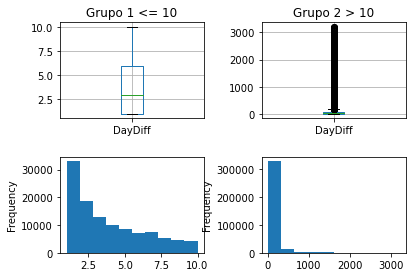

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.tight_layout()


plt.subplot(2, 2, 1)
plt.title('Grupo 1 <= 10')
ax1=df_G1.boxplot(column=['DayDiff']) 


plt.subplot(2, 2, 2)
plt.title('Grupo 2 > 10')
ax2=df_G2.boxplot(column=['DayDiff']) 
 

plt.subplot(2, 2, 3)
ax3=df_G1['DayDiff'].plot(kind='hist') 


plt.subplot(2, 2, 4)
ax4=df_G2['DayDiff'].plot(kind='hist')

plt.show
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


### Remoção de OUTLIER

In [ ]:
#dataset= remove_outlier(dataset,"last_order")
Q1 = df_G1['DayDiff'].quantile(0.25)
Q3 = df_G1['DayDiff'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (df_G1['DayDiff'] >= Q1 - 1.5 * IQR) & (df_G1['DayDiff'] <= Q3 + 1.5 *IQR)
df_G1= df_G1.loc[filter] 
#dataset = dataset[dataset['last_order']<dataset['last_order'].quantile(0.95)]
df_G1.shape

(112435, 13)

In [ ]:
#dataset= remove_outlier(dataset,"last_order")
Q1 = df_G2['DayDiff'].quantile(0.25)
Q3 = df_G2['DayDiff'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (df_G2['DayDiff'] >= Q1 - 1.5 * IQR) & (df_G2['DayDiff'] <= Q3 + 1.5 *IQR)
df_G2= df_G2.loc[filter] 
#dataset = dataset[dataset['last_order']<dataset['last_order'].quantile(0.95)]
df_G2.shape

(306606, 13)

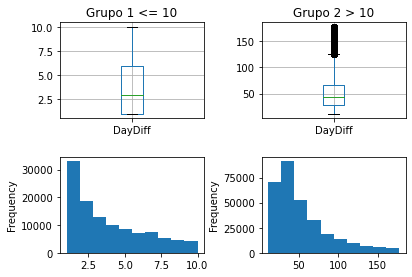

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.tight_layout()


plt.subplot(2, 2, 1)
plt.title('Grupo 1 <= 10')
ax1=df_G1.boxplot(column=['DayDiff']) 

plt.subplot(2, 2, 2)
plt.title('Grupo 2 > 10')
ax2=df_G2.boxplot(column=['DayDiff']) 
 

plt.subplot(2, 2, 3)
ax3=df_G1['DayDiff'].plot(kind='hist') 


plt.subplot(2, 2, 4)
ax4=df_G2['DayDiff'].plot(kind='hist')

plt.show
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

In [ ]:
# Using DataFrame.mean() method to get column average last order
df_last_order_media = df_G1["DayDiff"].mean()
df_dsp = df_G1["DayDiff"].std()

print("A média do GRUPO 1 ..........: ", df_last_order_media)

print("O desvio padrão do GRUPO 1..:", df_dsp)

A média do GRUPO 1 ..........:  3.7106594921510205
O desvio padrão do GRUPO 1..: 2.731699802491351


In [ ]:
# Using DataFrame.mean() method to get column average DayDiff
# ---- tasks ----
    # fazer uma subamostra pra verificar o intervalo de confiança????
       ### Calcular o intervalo de confiança. 
       
df_last_order_media = df_G2["DayDiff"].mean()
df_dsp = df_G2["DayDiff"].std()

print("A média do GRUPO 2 ..........: ", df_last_order_media)

print("O desvio padrão do GRUPO 2..:", df_dsp)

A média do GRUPO 2 ..........:  53.2519944162867
O desvio padrão do GRUPO 2..: 35.287868122317384


In [ ]:
import numpy as np, scipy.stats as st
def subamostra(data, fraci):
      df_sub = data.sample(frac=float(fraci))
      
      df_last_order_media = np.around(df_sub["DayDiff"].mean(),decimals=1)
      df_dsp = np.around(df_sub["DayDiff"].std(),decimals=1)

      x=st.t.interval(alpha=0.95, df=len(df_sub["DayDiff"])-1, loc=np.mean(df_sub["DayDiff"]), scale=st.sem(df_sub["DayDiff"])) 
    
      y = format(float(fraci),'.0%')
      print(f' {y}     | {df_last_order_media}  | {df_dsp} | {x}')
      print ("__________________________________________________________________")


In [ ]:
lo = ['0.10' ,'0.15', '0.20','0.25', '0.30' ,'0.35', '0.40' ,'0.45', '0.50' ,'0.55', '0.60', '0.65', '0.70' ,'0.75', '0.80', '0.85', '0.90','0.95']
print ("AMOSTRAS | MÉDIA | D.P  | INT. CONFIANÇA")
print ("__________________________________________________________________")

for x in lo:
    subamostra(df_G2,x)

AMOSTRAS | MÉDIA | D.P  | INT. CONFIANÇA
__________________________________________________________________
 10%     | 53.1  | 35.3 | (52.73809192803987, 53.52732668192066)
__________________________________________________________________
 15%     | 53.4  | 35.4 | (53.078497778482806, 53.72531166249478)
__________________________________________________________________
 20%     | 53.0  | 35.1 | (52.75938973462863, 53.31565796518058)
__________________________________________________________________
 25%     | 53.3  | 35.3 | (53.027089476034426, 53.5262946496244)
__________________________________________________________________
 30%     | 53.2  | 35.2 | (52.931494819687245, 53.38619777234163)
__________________________________________________________________
 35%     | 53.4  | 35.4 | (53.229083626267986, 53.652718968036474)
__________________________________________________________________
 40%     | 53.2  | 35.2 | (53.00344745715992, 53.39721463249941)
_______________________________

### Pré-processamento

In [ ]:
for p in df_G2['payments'].unique():
  print(p)

Dinheiro
Carteira
Dinheiro, Carteira
Cartão Credishop
Cartão Visa
Cheque
Cartão Master
Cartão Hiper
Cartão Elo
Carteira, Cartão Master
Dinheiro, Cartão Visa
Dinheiro, Cartão Master
PIX
Crédito de Cliente
Dinheiro, Crédito de Cliente
Boleto Bancário
Cartão de Crédito
Dinheiro, Cartão de Crédito
Cartão de Débito
Carteira, Cartão Visa
Carteira, Cartão Hiper
Carteira, Crédito de Cliente
Dinheiro, Cartão de Débito
Dinheiro, Boleto Bancário
Dinheiro, Cartão Hiper
Cartão Hiper, Cartão Outro
Dinheiro, Cartão Elo
Cartão Outro
Cartão Visa, Cartão Master
Vale Gás
Carteira, Cartão de Débito
Carteira, Cartão de Crédito
Transferência Bancária
Dinheiro, Vale Gás
Cartão de Crédito, Cartão de Débito
Dinheiro, Cartão Credishop
Dinheiro, PIX


In [ ]:
df_G2['payments'].nunique()

37

In [ ]:
payment_terms = {
    'Débito': 'Débito',
    'Pix': 'Pix',
    'Dinheiro': 'Dinheiro',
    'Crédito': 'Crédito',
    'Cartão': 'Crédito',
    'Cheque': 'Cheque',
    'Vale': 'Vale',
    'Carteira': 'Carteira',
    'Transferência': 'Transferência Bancária'
}
for key, value in payment_terms.items():
  df_G2.loc[df_G2['payments'].str.contains(key, case=False),'payment'] = value

In [ ]:
df_G2.head()

,sale_id,client_id,date,name_product,quantity_product,value_product,total,payments,city,state_federation,InvoiceDay,PrevInvoiceDate,DayDiff,payment
0,155595,29293,2013-05-18 23:12:27,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí,2013-05-18,2013-04-09,39.0,Dinheiro
1,157615,29293,2013-06-25 22:21:47,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí,2013-06-25,2013-05-18,38.0,Dinheiro
2,160001,29293,2013-08-11 21:51:12,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí,2013-08-11,2013-06-25,47.0,Dinheiro
3,163353,29293,2013-10-17 22:57:38,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí,2013-10-17,2013-08-11,67.0,Dinheiro
4,161757,29293,2013-12-03 20:31:04,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí,2013-12-03,2013-10-17,47.0,Dinheiro


In [ ]:
df_G2['payments'].unique()

['Dinheiro', 'Carteira', 'Dinheiro, Carteira', 'Cartão Credishop', 'Cartão Visa', ..., 'Transferência Bancária', 'Dinheiro, Vale Gás', 'Cartão de Crédito, Cartão de Débito', 'Dinheiro, Cartão Credishop', 'Dinheiro, PIX']
Length: 37
Categories (179, object): ['Boleto Bancário', 'Boleto Bancário, Cartão de Crédito', 'Boleto Bancário, Cartão de Débito', 'Boleto Bancário, Crédito de Cliente', ..., 'Vale Gás, Cartão de Débito', 'Vale Gás, Crédito de Cliente', 'Vale Gás, PIX', 'Vale Gás, Transferência Bancária']

In [ ]:
df_G2.head()

,sale_id,client_id,date,name_product,quantity_product,value_product,total,payments,city,state_federation,InvoiceDay,PrevInvoiceDate,DayDiff,payment
0,155595,29293,2013-05-18 23:12:27,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí,2013-05-18,2013-04-09,39.0,Dinheiro
1,157615,29293,2013-06-25 22:21:47,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí,2013-06-25,2013-05-18,38.0,Dinheiro
2,160001,29293,2013-08-11 21:51:12,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí,2013-08-11,2013-06-25,47.0,Dinheiro
3,163353,29293,2013-10-17 22:57:38,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí,2013-10-17,2013-08-11,67.0,Dinheiro
4,161757,29293,2013-12-03 20:31:04,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí,2013-12-03,2013-10-17,47.0,Dinheiro


In [ ]:
df_G2['payments'] = df_G2['payments'].astype('category')

In [ ]:
product_terms = {
    r'^.*GLP\s?13\s?KG.*$': r'GLP 13 KG'
}

for key, value in product_terms.items():
  df_G2['name_product'] = (
      df_G2['name_product'].str.replace(key, value)
  )

In [ ]:
df_G2['name_product'].unique()

array(['GLP 13 KG'], dtype=object)

In [ ]:
df_G2 = pandas.get_dummies(
      df_G2, prefix='d', columns=['payments', 'city', 'state_federation']
 
)

In [ ]:
df_G2.head()

,sale_id,client_id,date,name_product,quantity_product,value_product,total,InvoiceDay,PrevInvoiceDate,DayDiff,...,d_Pará,d_Pernambuco,d_Piauí,d_Rio Grande do Norte,d_Rio Grande do Sul,d_Rio de Janeiro,d_Santa Catarina,d_Sergipe,d_São Paulo,d_Tocantins
0,155595,29293,2013-05-18 23:12:27,GLP 13 KG,1,40.0,40.0,2013-05-18,2013-04-09,39.0,...,0,0,1,0,0,0,0,0,0,0
1,157615,29293,2013-06-25 22:21:47,GLP 13 KG,1,45.0,45.0,2013-06-25,2013-05-18,38.0,...,0,0,1,0,0,0,0,0,0,0
2,160001,29293,2013-08-11 21:51:12,GLP 13 KG,1,45.0,45.0,2013-08-11,2013-06-25,47.0,...,0,0,1,0,0,0,0,0,0,0
3,163353,29293,2013-10-17 22:57:38,GLP 13 KG,1,45.0,45.0,2013-10-17,2013-08-11,67.0,...,0,0,1,0,0,0,0,0,0,0
4,161757,29293,2013-12-03 20:31:04,GLP 13 KG,1,40.0,40.0,2013-12-03,2013-10-17,47.0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Como só tem uma categoria de producos (GLP 13 KG) não vamos usar a coluna
X = df_G2.drop(['client_id', 'DayDiff', 'date', 'InvoiceDay', 'PrevInvoiceDate','name_product','payment'], axis=1)
Y = df_G2['DayDiff']

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, train_size = 0.7, test_size=0.3, random_state=4
)
print("Tamanho do set train:",len(x_train))
print("Tamanho do set test:",len(x_test))

Tamanho do set train: 214624
Tamanho do set test: 91982


In [ ]:
duplicate_columns_train = x_train.columns[x_train.columns.duplicated()]
duplicate_columns_train

Index(['d_Rio de Janeiro', 'd_São Paulo'], dtype='object')

In [ ]:
x_train= x_train.T.drop_duplicates().T


In [ ]:
duplicate_columns_test = x_test.columns[x_test.columns.duplicated()]
duplicate_columns_test

Index(['d_Rio de Janeiro', 'd_São Paulo'], dtype='object')

In [ ]:
x_test= x_test.T.drop_duplicates().T

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from pandas.core.common import SettingWithCopyWarning
import warnings

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
scaler = MinMaxScaler()
columns = [
    'quantity_product', 'value_product', 'total',
]

x_train[columns] = scaler.fit_transform(x_train[columns])
x_test[columns]  = scaler.transform(x_test[columns])

In [ ]:
x_train.head()

,sale_id,quantity_product,value_product,total,d_Boleto Bancário,"d_Boleto Bancário, Cartão de Crédito",d_Carteira,"d_Carteira, Cartão Master","d_Carteira, Cartão Visa","d_Carteira, Cartão de Crédito",...,d_Sussuapara,d_São Gonçalo do Piauí,d_São José do Piauí,d_São João da Canabrava,d_São Luís do Piauí,d_São Miguel do Tapuio,d_São Pedro do Piauí,d_Teresina,d_Valença do Piauí,d_Piauí
338111,2361034.0,0.0,0.068966,0.068966,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
63727,164520.0,0.0,0.013793,0.013793,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
107730,402183.0,0.0,0.028736,0.028736,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
233957,765824.0,0.0,0.045977,0.045977,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32834,2884188.0,0.0,0.091954,0.091954,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
len(x_train.columns)

78

In [ ]:
yscaler = MinMaxScaler()
y_train = yscaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = yscaler.transform(y_test.values.reshape(-1, 1))

## Simple practical Exemplo

In [ ]:
# import pandas as pd
# def transform_record(client_id, dataframe, scaler, model, normalizer):
#   df = dataframe[dataframe['client_id'] == client_id]
#   df = df.iloc[-1:]
#   X = df.drop(['client_id', 'DayDiff', 'date', 'name_product'], axis=1)

#   dataframe['date'] = pd.to_numeric(pd.to_datetime(dataframe['date']))
#   date = dataframe['date']

#   columns = [
#     'quantity_product', 'value_product', 'total',
#   ]
#   X[columns] = scaler.transform(X[columns])
#   y_predicted = model.predict(X.values)
#   y = normalizer.inverse_transform(y_predicted.reshape(-1, 1))
#   new_date = date.values[0] + (y[0] * numpy.timedelta64(1, 'D'))
#   return new_date[0], date.values[0]

###Regressão Linear

In [ ]:
# new_date, old_date = transform_record(
#     29293, dataframe=df_G2, scaler=scaler, model=r, normalizer=yscaler
# )

In [ ]:
# import datetime

In [ ]:
# n_date = datetime.datetime.fromtimestamp(
#     new_date.item() / 10**9
# ).strftime('%Y.%m.%d')

# o_date = datetime.datetime.fromtimestamp(
#     old_date.item() / 10**9
# ).strftime('%Y.%m.%d')

In [ ]:
print(f'Última compra em: {o_date}. Próxima data de compra estimada em: {n_date}')

NameError: ignored

### Rede Neural

In [ ]:
# new_date, old_date = transform_record(
#     29293, dataframe=dataset, scaler=scaler, model=nnr, normalizer=yscaler
# )

In [ ]:
# n_date = datetime.datetime.fromtimestamp(
#     new_date.item() / 10**9
# ).strftime('%Y.%m.%d')

# o_date = datetime.datetime.fromtimestamp(
#     old_date.item() / 10**9
# ).strftime('%Y.%m.%d')

In [ ]:
print(f'Última compra em: {o_date}. Próxima data de compra estimada em: {n_date}')

## Funções

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import pandas as pd
import numpy as np, scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


In [ ]:
def split_dataset(data):
    X = data.drop(['client_id', 'DayDiff', 'date', 'InvoiceDay', 'PrevInvoiceDate','name_product','payments'], axis=1)
    Y = data['DayDiff']
    x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 0.7, test_size=0.3, random_state=4)
    #x_train= array(split(x_train,len(x_train)/7))
    #x_test= array(split(x_test,len(x_test)/7))
    return x_train, x_test

In [ ]:
def load_dataset():
    dataset_path = '/Users/ailtonrodrigues/Desktop/REVGAS/input/dados_vendas.csv'
    dataset_ori = pd.read_csv(dataset_path)
    #train, test = split_dataset(dataset_ori)

    return dataset_ori
 

In [ ]:
def valida_test_train(train,test):
    # validate train data
    print(train.shape)
    print(train[0, 0, 0], train[-1, -1, 0])
    # validate test
    print(test.shape)
    print(test[0, 0, 0], test[-1, -1, 0])


In [ ]:
def filtra_dataset(data,value):
    dataset = data.query("(state_federation==@value) & (quantity_product<=2) & (name_product=='GLP 13KG')").reset_index(drop=True)
    return dataset

In [ ]:
def media_desvio(data):

    # média 
    
    df_last_order_media = np.around(data["DayDiff"].mean(),decimals=1)

    #desvio padrão
    df_dsp = np.around(data["DayDiff"].std(),decimals=2)


    # Coeficiente de variação
    cv =   np.around(df_dsp/df_last_order_media,decimals=2)

    fraci               = 1
    tam                 = data.shape
    y = format(float(fraci),'.0%')
    

    x= st.t.interval(alpha=0.95, df=len(data["DayDiff"])-1, loc=np.mean(data["DayDiff"]), scale=st.sem(data["DayDiff"])) 
   #print(f'  %   | CV  | Tam.          | Média  | DvP   | Interv. Conf.                        ')

    print(f' {y} |{cv}  | {tam}  | {df_last_order_media}  | {df_dsp} | {x} | ')
#   print ("_____________________________________________________________________________")

    # print("   A média ..........: ", df_last_order_media)
    # print("   O desvio padrão...:", df_dsp)

In [ ]:
def extrai_states(data):
    estados = []
    data = data[data['state_federation'].notna()]
    for estados_l in data['state_federation'].unique():
        estados.append(estados_l)
    return estados

In [ ]:
def filtra_dataset_grupo(data):
    #df_G2 = dataset.query('DayDiff>10')
    df_G3 = data.query("DayDiff>10").reset_index(drop=True)

    df_G3.sort_values(['client_id','date'], ascending=True, inplace=True)
    return df_G3

In [ ]:
def create_atributos (dataset):
    #df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    dataset['InvoiceDay']      = dataset['date'].dt.date
    dataset['InvoiceDay']      = pd.to_datetime(dataset['InvoiceDay'],errors='coerce')

    dataset['PrevInvoiceDate'] = dataset.groupby('client_id')['InvoiceDay'].shift(1)
    dataset['DayDiff']         = (dataset['InvoiceDay'] - dataset['PrevInvoiceDate']).dt.days
    dataset['DayDiff']         = dataset['DayDiff'].fillna(0)
    dataset['PrevInvoiceDate'] = dataset['PrevInvoiceDate'].fillna(0)
    dataset['DayDiff']         = pd.to_numeric(dataset['DayDiff'], errors='coerce')
    dataset = dataset[(dataset != 0).all(1)]
    return dataset

In [ ]:
def set_atributos_tipos(dataset_ori):
    dataset_ori['client_id']        = pd.to_numeric(dataset_ori['client_id'])
    dataset_ori['quantity_product'] = pd.to_numeric(dataset_ori['quantity_product'], errors='coerce')
    dataset_ori['name_product']     = dataset_ori['name_product'].astype('category')
    dataset_ori['value_product']    = pd.to_numeric(dataset_ori['value_product'], errors='coerce')
    dataset_ori['payments']         = dataset_ori['payments'].astype('category')
    dataset_ori['total']            = dataset_ori['total'].astype('float32')
    dataset_ori['date']             = dataset_ori['date'].astype('datetime64')
    dataset_ori['city']             = dataset_ori['city'].astype('category')
    dataset_ori['state_federation'] = dataset_ori['state_federation'].astype('category')

In [ ]:
def box_plot_hist(df_G2):
    
    plt.tight_layout()
    plt.subplot(2, 2, 1)
    ax1=df_G2.boxplot(column=['DayDiff']) 

    plt.subplot(2, 2, 2)
    ax4=df_G2['DayDiff'].plot(kind='hist')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.9)
     

In [ ]:
def repeat_fun(times, f, *args):
    for i in range(times): f(*args)

In [ ]:
def remove_ruidos(data):
    Q1 = data['DayDiff'].quantile(0.25)
    Q3 = data['DayDiff'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 

    filter = (data['DayDiff'] >= Q1 - 1.5 * IQR) & (data['DayDiff'] <= Q3 + 1.5 *IQR)
    data = data.loc[filter] 
    return data

In [ ]:
def subamostra(data, fraci):
      import numpy as np, scipy.stats as st
      df_sub = data.sample(frac=float(fraci),random_state=1)
      
      # média
      df_last_order_media = np.around(df_sub["DayDiff"].mean(),decimals=1)
      
      # desvio padrão
      df_dsp = np.around(df_sub["DayDiff"].std(),decimals=2)

      # Coeficiente de variação
      cv =   np.around(df_dsp/df_last_order_media,decimals=2)


      x= st.t.interval(alpha=0.95, df=len(df_sub["DayDiff"])-1, loc=np.mean(df_sub["DayDiff"]), scale=st.sem(df_sub["DayDiff"])) 
      
      tam = df_sub.shape
      y = format(float(fraci),'.0%')
    #  print(f'  %   | CV| Tam.         | Média | DvP   | Interv. Conf.                        ')

      print(f' {y}  |{cv}| {tam}  | {df_last_order_media}  | {df_dsp} | {x} | ')
      return df_sub,df_last_order_media 
      


In [ ]:
def gerar_csv_estado(data,estado):
   data.to_csv('data' + estado + '.csv')

## LSTM - em estudo ...

In [ ]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
import numpy as np

from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM


In [ ]:
# fix random seed for reproducibility
seed = np.random.seed(7)

In [ ]:
def to_supervised(train, n_input, n_out=43):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [ ]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [ ]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [ ]:
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores


In [ ]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores


In [ ]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

### Teste - em andamento

In [ ]:
# load the new file
dataset = read_csv('XXXXXXXX.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

## Remove ruídos

# split into train and test
train, test = split_dataset(dataset.values)

# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)


# summarize scores
summarize_scores('lstm', score, scores)

# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

## Modulo Main

In [ ]:
def main():
    #my_dictionary = {}
	#1. carregar dataset aqui
    print("> Carregando dataset...")
    dataset_ori= load_dataset()
    lista_media_amostra = []
    print("> Setando atributos...")
	#2- seta atributos
    set_atributos_tipos(dataset_ori)

    print("> Extraindo estados ...")
    #3 - extrai estados e depois Filtra dataset
    estados = extrai_states(dataset_ori)
    print(estados)
    print(len(estados))
    length = len(estados)
    for i in range(length):
        print("> Filtrando pelo estado ...",estados[i])
        nome = estados[i]
        #my_dictionary.append(estados[i])
        dataf= filtra_dataset(dataset_ori,estados[i])
        #dataf.shape

        print("> Criando atributos ...")
        #4 -  Create atributos 
        create_atributos(dataf)
        
        print("> Filtrando dataset por Grupo >10 dias ...")
        #5 - filtra dataset_grupo
        dataf_grupo = filtra_dataset_grupo(dataf)
        #dataf_grupo.to_csv(r'/Users/ailtonrodrigues/Desktop/REVGAS/outputs/CSV/'+estados[i]+'.csv',encoding="utf-8",index=False)
        print("========================================================================================================")
        print(" ESTADO:",estados[i])
        print("========================================================================================================")
        print("## POPULAÇÃO  ...")
        print("  **** COM RUÍDOS ****   ")

        #6- media desvio padrao
        count_row_pop = dataf_grupo.shape[0]
        if (count_row_pop>=30) : 
            media_desvio(dataf_grupo)
            #ag=box_plot_hist(dataf_grupo)
            print("GRÁFICOS...")
            ag=box_plot_hist(dataf_grupo)
            plt.show(ag)
            print("> Removendo ruídos...")
            for i in range(9):   
                dataf_grupo=remove_ruidos(dataf_grupo)
                #dataf_grupo.shape           
            dataf_grupo.to_csv(r'/Users/ailtonrodrigues/Desktop/REVGAS/outputs/CSV/'+nome+'.csv',encoding="utf-8",index=False)
            print("  **** SEM RUÍDOS ****   ")
            nome=""
            #6- media desvio padrao
            count_row_pop_2 = dataf_grupo.shape[0]
            if (count_row_pop_2>=30):      
                media_desvio(dataf_grupo)
                print("GRÁFICOS...")
                #aw=box_plot_hist(dataf_grupo)
                aw=box_plot_hist(dataf_grupo)
                plt.show(aw)
            else:
                print("Dados inferior a 30")  
        else :
            print("População inferior a 30")
        #file_name = estados[i]
        
        #my_dictionary.update( [(estados[i], dataf_grupo)] )
#        print("============================================")
        print("## SUBAMOSTRA...")
        #8-subamostra
        fraci = 0.1
        amostra, media = subamostra(dataf_grupo, fraci)
        count_row_amo = amostra.shape[0]
        if (count_row_amo>=30) : 
             lista_media_amostra.append(media)
             print("GRÁFICOS...")
             ac=box_plot_hist(amostra)
#            print("============================================")

             plt.show(ac)
        else :
             print("Amostra inferior a 30")    
             print()
             print()

       
   
        #10- Splita dataset
        # split into standard weeks
        #x_train, y_test = split_dataset(dataf_grupo)
    print("Lista contendo a média das amostras com número superior ou igual a 30")
    print(lista_media_amostra)
    plt.hist(lista_media_amostra, 10)
    plt.show()
    count = sum(lista_media_amostra)
    avg = count/len(lista_media_amostra)
    print("Média das médias",avg)



> Carregando dataset...
> Setando atributos...
> Extraindo estados ...
['Piauí', 'Maranhão', 'Sergipe', 'São Paulo', 'Paraná', 'Espírito Santo', 'Bahia', 'Rio Grande do Norte', 'Pará', 'Minas Gerais', 'Amazonas', 'Rio de Janeiro', 'Pernambuco', 'Rio Grande do Sul', 'Goiás', 'Mato Grosso do Sul', 'Paraíba', 'Santa Catarina', 'Ceará', 'Alagoas', 'Distrito Federal', 'Amapá', 'Tocantins', 'Mato Grosso']
24
> Filtrando pelo estado ... Piauí
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Piauí
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |1.91  | (348011, 13)  | 106.2  | 202.6 | (105.51112170614242, 106.85737814012681) | 
GRÁFICOS...


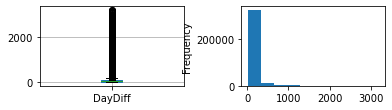

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.51  | (275097, 13)  | 44.0  | 22.34 | (43.87873568978357, 44.0456764266699) | 
GRÁFICOS...


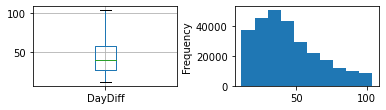

## SUBAMOSTRA...
 10%  |0.51| (27510, 13)  | 44.1  | 22.49 | (43.864889043001085, 44.39647046263323) | 
GRÁFICOS...


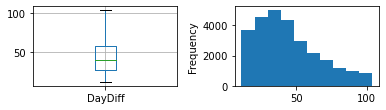

> Filtrando pelo estado ... Maranhão
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Maranhão
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |1.45  | (78698, 13)  | 91.9  | 133.54 | (90.97841428086423, 92.84447829582132) | 
GRÁFICOS...


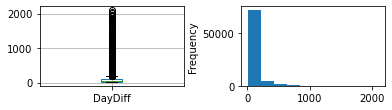

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.55  | (62376, 13)  | 44.4  | 24.5 | (44.20322947456154, 44.5877478243996) | 
GRÁFICOS...


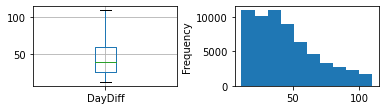

## SUBAMOSTRA...
 10%  |0.55| (6238, 13)  | 44.7  | 24.6 | (44.113477720775485, 45.33474286274487) | 
GRÁFICOS...


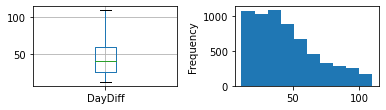

> Filtrando pelo estado ... Sergipe
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Sergipe
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |1.25  | (14151, 13)  | 81.1  | 101.13 | (79.4778158909552, 82.81050295576942) | 
GRÁFICOS...


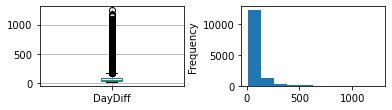

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.54  | (12014, 13)  | 50.1  | 27.0 | (49.63343475449187, 50.59912725649531) | 
GRÁFICOS...


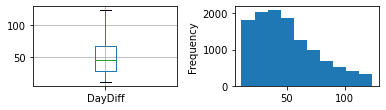

## SUBAMOSTRA...
 10%  |0.55| (1201, 13)  | 50.4  | 27.67 | (48.80007359080991, 51.93264914024754) | 
GRÁFICOS...


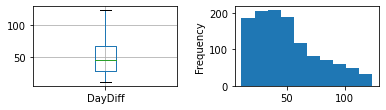

> Filtrando pelo estado ... São Paulo
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: São Paulo
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |0.99  | (48734, 13)  | 95.2  | 93.88 | (94.4133742002196, 96.08049045279473) | 
GRÁFICOS...


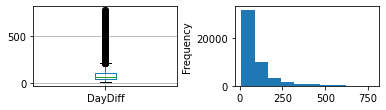

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.55  | (41368, 13)  | 63.2  | 34.52 | (62.821480520668665, 63.48687376283549) | 
GRÁFICOS...


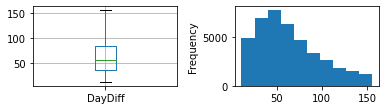

## SUBAMOSTRA...
 10%  |0.55| (4137, 13)  | 62.8  | 34.46 | (61.71283075200265, 63.8133959823459) | 
GRÁFICOS...


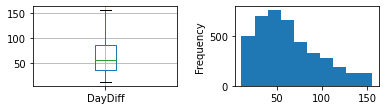

> Filtrando pelo estado ... Paraná
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Paraná
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |0.91  | (17097, 13)  | 67.5  | 61.7 | (66.58388432191302, 68.43360412635275) | 
GRÁFICOS...


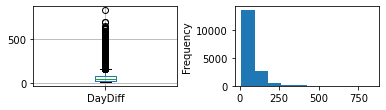

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.57  | (15481, 13)  | 52.4  | 30.02 | (51.89669704713412, 52.842402494239174) | 
GRÁFICOS...


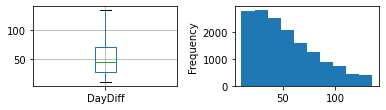

## SUBAMOSTRA...
 10%  |0.58| (1548, 13)  | 53.0  | 30.71 | (51.42514001033497, 54.48700469250741) | 
GRÁFICOS...


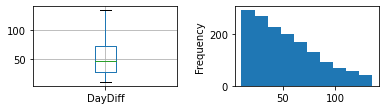

> Filtrando pelo estado ... Espírito Santo
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Espírito Santo
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |0.77  | (5277, 13)  | 64.3  | 49.27 | (62.999622449277005, 65.65908514973759) | 
GRÁFICOS...


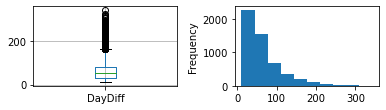

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.59  | (4781, 13)  | 52.1  | 30.53 | (51.256387001190454, 52.98749503185703) | 
GRÁFICOS...


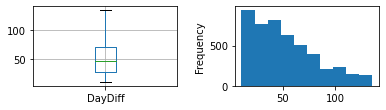

## SUBAMOSTRA...
 10%  |0.59| (478, 13)  | 52.5  | 31.17 | (49.68013667428437, 55.28220642194994) | 
GRÁFICOS...


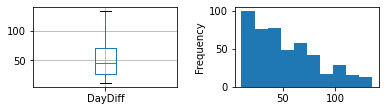

> Filtrando pelo estado ... Bahia
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Bahia
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |1.21  | (44598, 13)  | 61.8  | 74.71 | (61.06482813458215, 62.4516524250842) | 
GRÁFICOS...


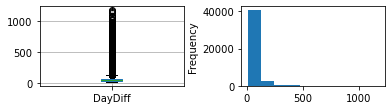

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.54  | (39153, 13)  | 41.8  | 22.67 | (41.593631749719314, 42.04276903693816) | 
GRÁFICOS...


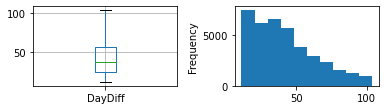

## SUBAMOSTRA...
 10%  |0.55| (3915, 13)  | 41.9  | 23.08 | (41.21602993144344, 42.66238641593842) | 
GRÁFICOS...


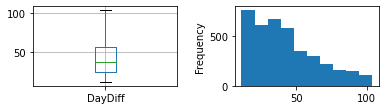

> Filtrando pelo estado ... Rio Grande do Norte
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Rio Grande do Norte
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |0.77  | (6632, 13)  | 67.4  | 52.15 | (66.19258492112615, 68.70307249745045) | 
GRÁFICOS...


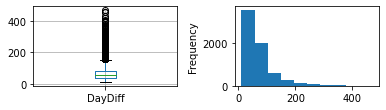

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.51  | (5963, 13)  | 53.8  | 27.67 | (53.07575802025693, 54.48050560543484) | 
GRÁFICOS...


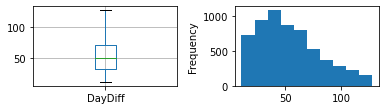

## SUBAMOSTRA...
 10%  |0.53| (596, 13)  | 52.2  | 27.74 | (49.95638127100936, 54.41945765516513) | 
GRÁFICOS...


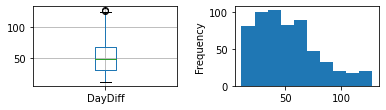

> Filtrando pelo estado ... Pará
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Pará
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |0.99  | (28918, 13)  | 48.2  | 47.63 | (47.62101550309933, 48.7189803472361) | 
GRÁFICOS...


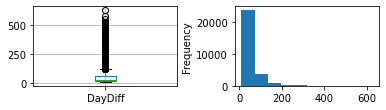

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.62  | (25846, 13)  | 35.4  | 21.97 | (35.17351602812416, 35.70925113120416) | 
GRÁFICOS...


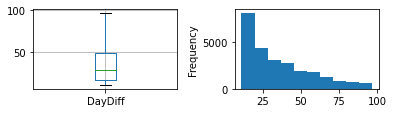

## SUBAMOSTRA...
 10%  |0.61| (2585, 13)  | 36.0  | 22.1 | (35.17577507115244, 36.8807046193698) | 
GRÁFICOS...


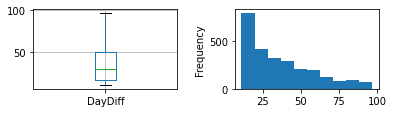

> Filtrando pelo estado ... Minas Gerais
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Minas Gerais
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |0.98  | (15077, 13)  | 67.6  | 66.46 | (66.56195320833156, 68.68378533381873) | 
GRÁFICOS...


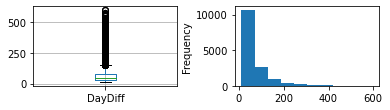

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.54  | (13009, 13)  | 46.5  | 25.0 | (46.02649022713704, 46.88564752365088) | 
GRÁFICOS...


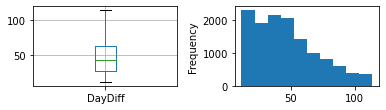

## SUBAMOSTRA...
 10%  |0.54| (1301, 13)  | 46.6  | 25.3 | (45.202053393675655, 47.95398042646271) | 
GRÁFICOS...


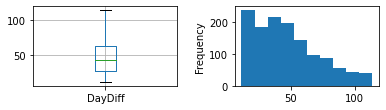

> Filtrando pelo estado ... Amazonas
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Amazonas
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
População inferior a 30
## SUBAMOSTRA...
 10%  |nan| (0, 13)  | nan  | nan | (nan, nan) | 
Amostra inferior a 30


> Filtrando pelo estado ... Rio de Janeiro
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Rio de Janeiro
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |0.86  | (17902, 13)  | 67.0  | 57.66 | (66.2008752219274, 67.89028777662024) | 
GRÁFICOS...


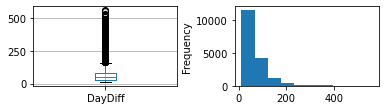

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.56  | (16210, 13)  | 52.7  | 29.75 | (52.19323377239975, 53.10917214987046) | 
GRÁFICOS...


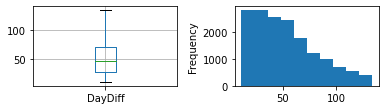

## SUBAMOSTRA...
 10%  |0.56| (1621, 13)  | 53.2  | 29.76 | (51.74265036419564, 54.64229719903693) | 
GRÁFICOS...


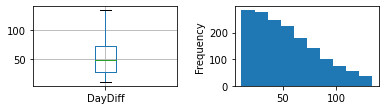

> Filtrando pelo estado ... Pernambuco
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Pernambuco
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |1.05  | (12843, 13)  | 82.2  | 86.4 | (80.6851553706914, 83.67410648401545) | 
GRÁFICOS...


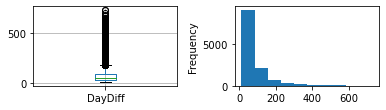

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.52  | (10612, 13)  | 50.6  | 26.24 | (50.107451761732236, 51.10608008900279) | 
GRÁFICOS...


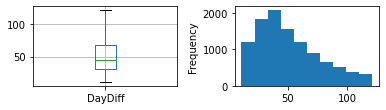

## SUBAMOSTRA...
 10%  |0.51| (1061, 13)  | 52.1  | 26.66 | (50.49772507894933, 53.70962647618734) | 
GRÁFICOS...


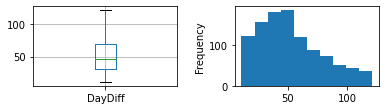

> Filtrando pelo estado ... Rio Grande do Sul
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Rio Grande do Sul
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |0.91  | (18029, 13)  | 75.0  | 68.15 | (73.96038809209794, 75.94997853944012) | 
GRÁFICOS...


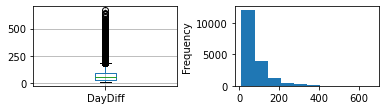

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.6  | (16179, 13)  | 56.8  | 34.35 | (56.29888946830237, 57.35745517598961) | 
GRÁFICOS...


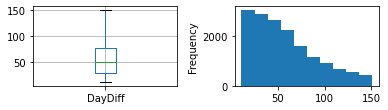

## SUBAMOSTRA...
 10%  |0.61| (1618, 13)  | 56.3  | 34.28 | (54.586935520445444, 57.929751747786945) | 
GRÁFICOS...


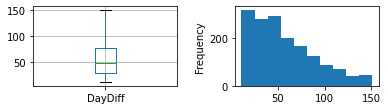

> Filtrando pelo estado ... Goiás
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Goiás
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |0.64  | (2105, 13)  | 58.8  | 37.76 | (57.21003320324056, 60.43842285376656) | 
GRÁFICOS...


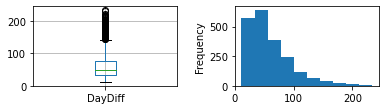

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.53  | (1982, 13)  | 52.4  | 27.79 | (51.200096346271565, 53.648541393385344) | 
GRÁFICOS...


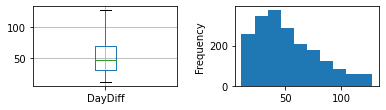

## SUBAMOSTRA...
 10%  |0.53| (198, 13)  | 53.9  | 28.83 | (49.9094617831726, 57.98952811581729) | 
GRÁFICOS...


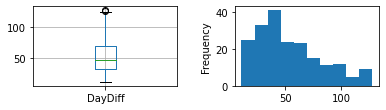

> Filtrando pelo estado ... Mato Grosso do Sul
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Mato Grosso do Sul
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |0.98  | (1250, 13)  | 73.5  | 72.26 | (69.53124264441561, 77.5503573555844) | 
GRÁFICOS...


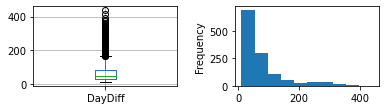

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.56  | (1049, 13)  | 46.7  | 26.21 | (45.13732486806054, 48.31358075634366) | 
GRÁFICOS...


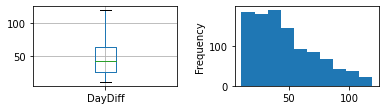

## SUBAMOSTRA...
 10%  |0.61| (105, 13)  | 48.2  | 29.24 | (42.50239847830746, 53.82141104550207) | 
GRÁFICOS...


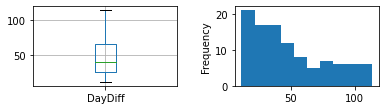

> Filtrando pelo estado ... Paraíba
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Paraíba
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |0.65  | (2567, 13)  | 50.5  | 32.89 | (49.21206696642887, 51.7579369291691) | 
GRÁFICOS...


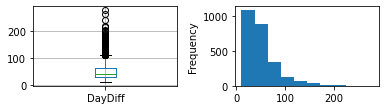

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.48  | (2364, 13)  | 43.2  | 20.94 | (42.40334420171061, 44.09242567984607) | 
GRÁFICOS...


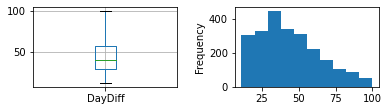

## SUBAMOSTRA...
 10%  |0.49| (236, 13)  | 43.2  | 21.1 | (40.446090705964124, 45.85899403979859) | 
GRÁFICOS...


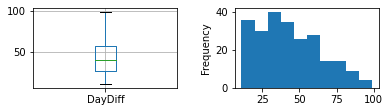

> Filtrando pelo estado ... Santa Catarina
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Santa Catarina
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |0.82  | (5296, 13)  | 86.1  | 71.02 | (84.21417609493972, 88.04035562711465) | 
GRÁFICOS...


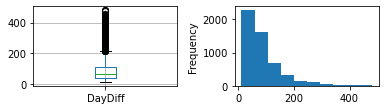

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.59  | (4785, 13)  | 67.9  | 40.32 | (66.75444039349499, 69.03991697327616) | 
GRÁFICOS...


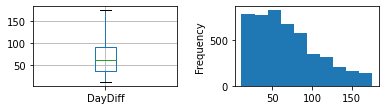

## SUBAMOSTRA...
 10%  |0.61| (478, 13)  | 66.3  | 40.75 | (62.67045014616778, 69.99482182035942) | 
GRÁFICOS...


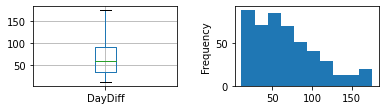

> Filtrando pelo estado ... Ceará
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Ceará
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |0.87  | (9379, 13)  | 68.0  | 59.19 | (66.78246754499733, 69.17872234731527) | 
GRÁFICOS...


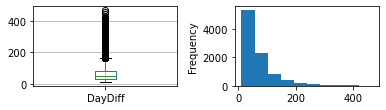

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.56  | (8214, 13)  | 49.9  | 28.16 | (49.33927120423836, 50.557490422253) | 
GRÁFICOS...


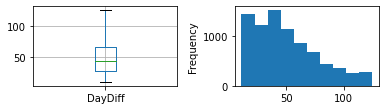

## SUBAMOSTRA...
 10%  |0.56| (821, 13)  | 50.4  | 28.23 | (48.46094526884092, 52.328336095349094) | 
GRÁFICOS...


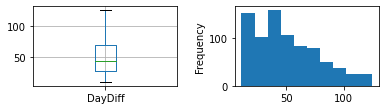

> Filtrando pelo estado ... Alagoas
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Alagoas
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |0.68  | (1990, 13)  | 45.4  | 30.73 | (44.019507693230636, 46.72119582435731) | 
GRÁFICOS...


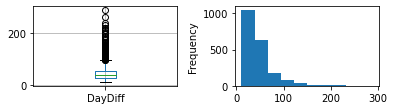

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.45  | (1821, 13)  | 38.2  | 17.17 | (37.36979152129653, 38.94761649627623) | 
GRÁFICOS...


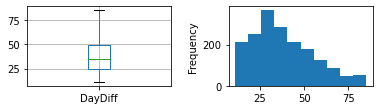

## SUBAMOSTRA...
 10%  |0.48| (182, 13)  | 35.8  | 17.27 | (33.27047027010577, 38.32293632330083) | 
GRÁFICOS...


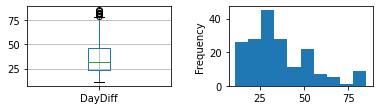

> Filtrando pelo estado ... Distrito Federal
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Distrito Federal
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
População inferior a 30
## SUBAMOSTRA...
 10%  |nan| (0, 13)  | nan  | nan | (nan, nan) | 
Amostra inferior a 30


> Filtrando pelo estado ... Amapá
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Amapá
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
 100% |0.5  | (105, 13)  | 30.7  | 15.44 | (27.72551237179089, 33.70305905678054) | 
GRÁFICOS...


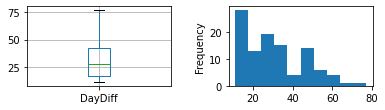

> Removendo ruídos...
  **** SEM RUÍDOS ****   
 100% |0.5  | (105, 13)  | 30.7  | 15.44 | (27.72551237179089, 33.70305905678054) | 
GRÁFICOS...


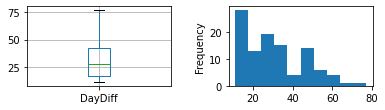

## SUBAMOSTRA...
 10%  |0.59| (10, 13)  | 26.0  | 15.46 | (14.94342161012941, 37.05657838987059) | 
Amostra inferior a 30


> Filtrando pelo estado ... Tocantins
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Tocantins
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
População inferior a 30
## SUBAMOSTRA...
 10%  |nan| (0, 13)  | nan  | nan | (nan, nan) | 
Amostra inferior a 30


> Filtrando pelo estado ... Mato Grosso
> Criando atributos ...
> Filtrando dataset por Grupo >10 dias ...
 ESTADO: Mato Grosso
## POPULAÇÃO  ...
  **** COM RUÍDOS ****   
População inferior a 30
## SUBAMOSTRA...
 10%  |nan| (0, 13)  | nan  | nan | (nan, nan) | 
Amostra inferior a 30


Lista contendo a média das amostras com número superior ou igual a 30
[44.1, 44.7, 50.4, 62.8, 53.0, 52.5, 41.9, 52.2, 36.0, 46.6, 53.2, 52.1, 56.3, 53.9, 48.2, 43.2, 66.3, 50.4, 35.8]


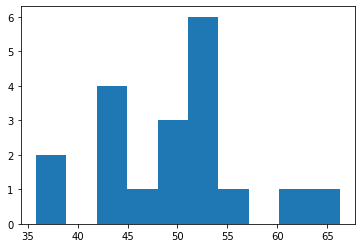

Média das médias 49.663157894736834


In [ ]:
if __name__=="__main__":
	main()

# LSTM - exemplo de apropriação


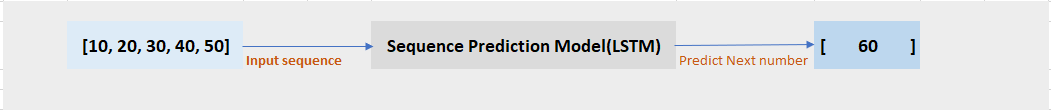

## Carregando dados

In [ ]:
data = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

In [ ]:
data

[10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200]

## Funções auxiliares

In [ ]:
def splitSequence(seq, n_steps):
    
    #Declare X and y as empty list
    X = []
    y = []
    
    for i in range(len(seq)):
        #get the last index
        lastIndex = i + n_steps
        
        #if lastIndex is greater than length of sequence then break
        if lastIndex > len(seq) - 1:
            break
            
        #Create input and output sequence
        seq_X, seq_y = seq[i:lastIndex], seq[lastIndex]
        
        #append seq_X, seq_y in X and y list
        X.append(seq_X)
        y.append(seq_y)       
     #Convert X and y into numpy array
    X = np.array(X)
    y = np.array(y)
    
    return X,y 


## Dividindo os dados

In [ ]:
n_steps = 6

X, y = splitSequence(data, n_steps = 6)



In [ ]:
print(X)

[[ 10  20  30  40  50  60]
 [ 20  30  40  50  60  70]
 [ 30  40  50  60  70  80]
 [ 40  50  60  70  80  90]
 [ 50  60  70  80  90 100]
 [ 60  70  80  90 100 110]
 [ 70  80  90 100 110 120]
 [ 80  90 100 110 120 130]
 [ 90 100 110 120 130 140]
 [100 110 120 130 140 150]
 [110 120 130 140 150 160]
 [120 130 140 150 160 170]
 [130 140 150 160 170 180]
 [140 150 160 170 180 190]]


In [ ]:
print(y)

[ 70  80  90 100 110 120 130 140 150 160 170 180 190 200]


In [ ]:
for i in range(len(X)):
    print(X[i], y[i])

[10 20 30 40 50 60] 70
[20 30 40 50 60 70] 80
[30 40 50 60 70 80] 90
[40 50 60 70 80 90] 100
[ 50  60  70  80  90 100] 110
[ 60  70  80  90 100 110] 120
[ 70  80  90 100 110 120] 130
[ 80  90 100 110 120 130] 140
[ 90 100 110 120 130 140] 150
[100 110 120 130 140 150] 160
[110 120 130 140 150 160] 170
[120 130 140 150 160 170] 180
[130 140 150 160 170 180] 190
[140 150 160 170 180 190] 200


In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))


In [ ]:
print(X[:2])

[[[10]
  [20]
  [30]
  [40]
  [50]
  [60]]

 [[20]
  [30]
  [40]
  [50]
  [60]
  [70]]]


## Criando o modelo

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = tf.keras.Sequential()
model.add(layers.LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

In [ ]:
model.layers

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                10400     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


## Compilando o modelo

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])

## Treinando o modelo

In [ ]:
model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 17668.1934 - accuracy: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 0s 10ms/step - loss: 18395.5488 - accuracy: 0.0000e+00
Epoch 3/200
1/1 [==============================] - 0s 9ms/step - loss: 9155.7266 - accuracy: 0.0000e+00
Epoch 4/200
1/1 [==============================] - 0s 14ms/step - loss: 1910.9297 - accuracy: 0.0000e+00
Epoch 5/200
1/1 [==============================] - 0s 14ms/step - loss: 1238.3627 - accuracy: 0.0000e+00
Epoch 6/200
1/1 [==============================] - 0s 14ms/step - loss: 893.3248 - accuracy: 0.0000e+00
Epoch 7/200
1/1 [==============================] - 0s 22ms/step - loss: 656.9183 - accuracy: 0.0000e+00
Epoch 8/200
1/1 [==============================] - 0s 19ms/step - loss: 218.1339 - accuracy: 0.0000e+00
Epoch 9/200
1/1 [==============================] - 0s 11ms/step - loss: 132.4791 - accuracy: 0.0000e+00
Epoch 10/200
1/1 [==============================] - 0s 12ms/

## Prevendo 

In [ ]:
test_data = np.array([90, 100, 110, 120, 130, 140])

#test_data = np.array([400, 410, 420, 430, 440,450])

test_data = test_data.reshape((1, n_steps, n_features))

test_data

array([[[ 90],
        [100],
        [110],
        [120],
        [130],
        [140]]])

In [ ]:
predictNextNumber = model.predict(test_data, verbose=1)
print(predictNextNumber)

1/1 [==============================] - 0s 24ms/step
[[151.8666  151.89691]]


## Predict again with different test data

In [ ]:
test_data = np.array([160, 170, 180, 190, 200])
test_data = test_data.reshape((1, n_steps, n_features))
test_data

array([[[160],
        [170],
        [180],
        [190],
        [200]]])

In [ ]:
predictNextNumber = model.predict(test_data, verbose=1)
print(predictNextNumber)

1/1 [==============================] - 0s 23ms/step
[[210.62526]]


# Tarefas


0 .[DONE]Calcular o Coeficiente de variacao (Cv_P, Cv_S) da amostra e da população e fazer a comparacao e estabelecer um limiar

1.  (0.5, 0.5)  =  9  - PI,  SE,  SP,  RN,  MG, PE, GO, PB, AL
2.  (0.6, 0.6)  =  9  - MA,  PR,   ES, PA, RJ,  RS , MS, SC,  CE
3.  (0.5, 0.6) =   1  - BA

Excluídos : MG, DF, AM, AP e TO
     

1.LSTM - janela -  (janela minima [2..n]) pedidos por cliente (experimentar com janelas menores)
               * * * * * * * |  *     
               ============ LSTM ============
               - Entrada : idcliente/qtde_dias/estado/cidade/mes/ 
               - Saida   : oitavo pedido 



Preparar o csv

       1. Piaui.csv (Todo)
                
            2. Ordenar por cliente (id)

            - idcliente (/qtde_dias / estado / cidade / mes/) n-2 

            3. Treinar com o id_cliente e sem id_cliente

            4. input(n-2,n-1)
            
            5. output(qtde_dias)
            
            6. n - instancias


#LSTM

In [ ]:
# Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [ ]:
def load_dataset_lstm(path):
    dataset_path = path
    dataset_ori = pd.read_csv(dataset_path)
    #train, test = split_dataset(dataset_ori)

    return dataset_ori


In [ ]:
df = load_dataset_lstm('/Users/ailtonrodrigues/Desktop/REVGAS/outputs/CSV/Piauí.csv')
df.head()

,sale_id,client_id,date,name_product,quantity_product,value_product,total,payments,city,state_federation,InvoiceDay,PrevInvoiceDate,DayDiff
0,155595,29293,2013-05-18 23:12:27,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí,2013-05-18,2013-04-09 00:00:00,39.0
1,157615,29293,2013-06-25 22:21:47,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí,2013-06-25,2013-05-18 00:00:00,38.0
2,160001,29293,2013-08-11 21:51:12,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí,2013-08-11,2013-06-25 00:00:00,47.0
3,163353,29293,2013-10-17 22:57:38,GLP 13KG,1,45.0,45.0,Dinheiro,Teresina,Piauí,2013-10-17,2013-08-11 00:00:00,67.0
4,161757,29293,2013-12-03 20:31:04,GLP 13KG,1,40.0,40.0,Dinheiro,Teresina,Piauí,2013-12-03,2013-10-17 00:00:00,47.0


In [ ]:
df.shape

(275097, 13)

In [ ]:
## using univariate feature(DayDiff  for given time)
#df['PrevInvoiceDate'] = df['PrevInvoiceDate'].astype('datetime64')

uni_data = df['DayDiff']
uni_data.index = df['InvoiceDay']

uni_data.head()

InvoiceDay
2013-05-18    39.0
2013-06-25    38.0
2013-08-11    47.0
2013-10-17    67.0
2013-12-03    47.0
Name: DayDiff, dtype: float64

<AxesSubplot:xlabel='InvoiceDay'>

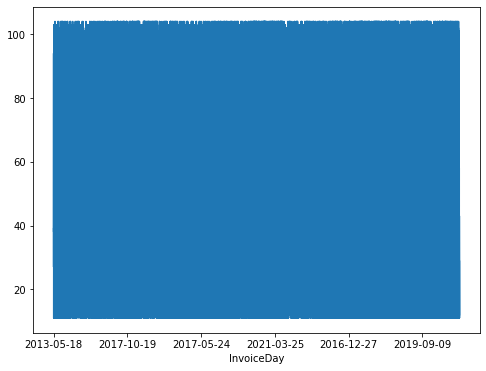

In [ ]:
uni_data.plot()


In [ ]:
uni_data = uni_data.values


In [ ]:
## train test split for simple time series moving window average
train_split = 265097
tf.random.set_seed(18)

### standardize data
uni_data_mean = uni_data[:train_split].mean()
uni_data_std = uni_data[:train_split].std()
uni_data  = (uni_data - uni_data_mean)/ uni_data_std

print(type(uni_data))

<class 'numpy.ndarray'>


In [ ]:
## utility functions

## funtion to create data for univariate forecasting

def univariate_data(dataset, start_idx , end_idx , history_size, target_size):
  data = []
  labels = []
  start_idx  = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx):
    idxs = range(i-history_size , i)
    data.append(np.reshape(dataset[idxs] , (history_size, 1))) ### reshape data
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

uni_data_history = 20   ## last 20 values
uni_data_future = 0     ## future data

x_train_uni , y_train_uni = univariate_data(uni_data , 0 , train_split , uni_data_history , uni_data_future)

x_val_uni , y_val_uni = univariate_data(uni_data , train_split , None ,uni_data_history , uni_data_future)

In [ ]:
print(x_train_uni.shape , y_train_uni.shape)
print(x_val_uni.shape , y_val_uni.shape)


(265077, 20, 1) (265077,)
(9980, 20, 1) (9980,)


In [ ]:
print('Single window of history data' , x_train_uni[0])

print('Target DayDiff to predict ' , y_train_uni[0])


Single window of history data [[-2.25356894e-01]
 [-2.70256092e-01]
 [ 1.33836693e-01]
 [ 1.03182066e+00]
 [ 1.33836693e-01]
 [-1.35558497e-01]
 [ 2.24409901e+00]
 [ 3.58332684e-01]
 [-3.60054489e-01]
 [-1.80457695e-01]
 [-3.15155290e-01]
 [ 4.03231882e-01]
 [ 9.86921460e-01]
 [-4.94752083e-01]
 [-3.15155290e-01]
 [-7.64147273e-01]
 [-4.94752083e-01]
 [-8.60902330e-04]
 [-3.15155290e-01]
 [-4.04953687e-01]]
Target DayDiff to predict  -0.6294496782511013


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

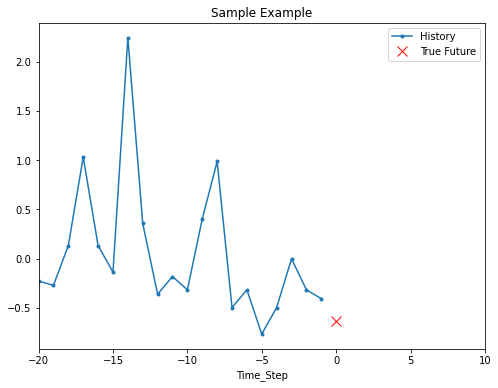

In [ ]:
### fucntion to create time steps
def create_time_steps(length):
  return list(range(-length,0))

### function to plot time series data

def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predcited']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt

plot_time_series([x_train_uni[0] , y_train_uni[0]] , 0 , 'Sample Example')

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

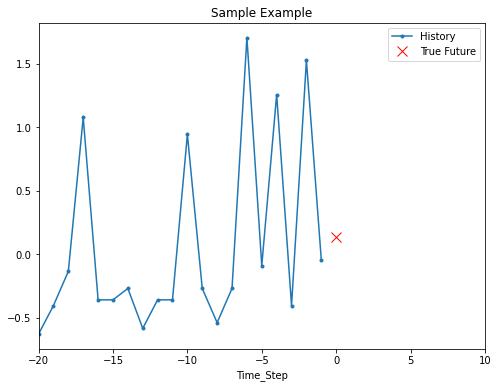

In [ ]:
i = 20
plot_time_series([x_train_uni[i], y_train_uni[i]] , 0 , 'Sample Example')

In [ ]:
def MWA(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

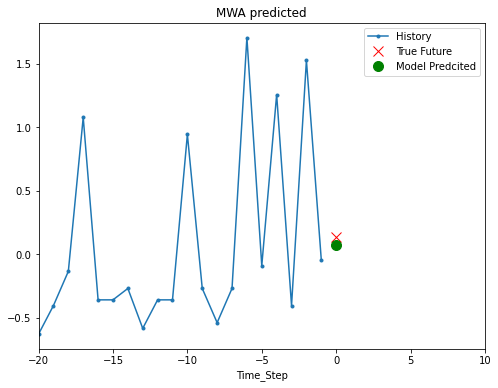

In [ ]:
i = 20
plot_time_series([x_train_uni[i] , y_train_uni[i] , MWA(x_train_uni[i])] , 0 , 'MWA predicted')


In [ ]:
## prepare tensorflow dataset
batch_size = 512
buffer_size = 10000

train_uni = tf.data.Dataset.from_tensor_slices((x_train_uni , y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni = tf.data.Dataset.from_tensor_slices((x_val_uni , y_val_uni))
val_uni = val_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_uni)
print(val_uni)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [ ]:
## Define LSTM model 

lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(16 , input_shape = x_train_uni.shape[-2:]), 
                                         tf.keras.layers.Dense(1)])

lstm_model.compile(optimizer = 'adam', loss = 'mae')

steps =20

EPOCHS =10

lstm_model.fit(train_uni , epochs = EPOCHS, steps_per_epoch = steps ,
               validation_data = val_uni, validation_steps = 50)

Epoch 1/10
20/20 [==============================] - 6s 133ms/step - loss: 0.5709 - val_loss: 0.8170
Epoch 2/10
20/20 [==============================] - 1s 54ms/step - loss: 0.5083 - val_loss: 0.8111
Epoch 3/10
20/20 [==============================] - 1s 54ms/step - loss: 0.5378 - val_loss: 0.8116
Epoch 4/10
20/20 [==============================] - 1s 51ms/step - loss: 0.5685 - val_loss: 0.8088
Epoch 5/10
20/20 [==============================] - 1s 64ms/step - loss: 0.6048 - val_loss: 0.8089
Epoch 6/10
20/20 [==============================] - 1s 51ms/step - loss: 0.6300 - val_loss: 0.8064
Epoch 7/10
20/20 [==============================] - 1s 53ms/step - loss: 0.5877 - val_loss: 0.8039
Epoch 8/10
20/20 [==============================] - 1s 58ms/step - loss: 0.5909 - val_loss: 0.7990
Epoch 9/10
20/20 [==============================] - 1s 55ms/step - loss: 0.5807 - val_loss: 0.7948
Epoch 10/10
20/20 [==============================] - 1s 70ms/step - loss: 0.5965 - val_loss: 0.7959


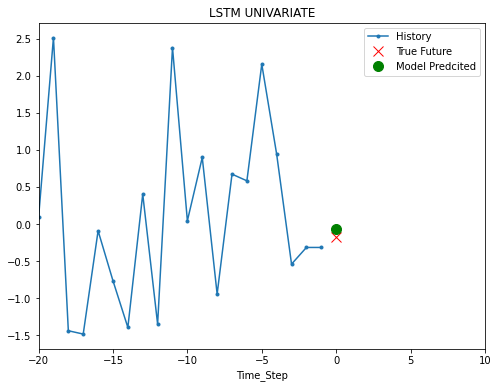

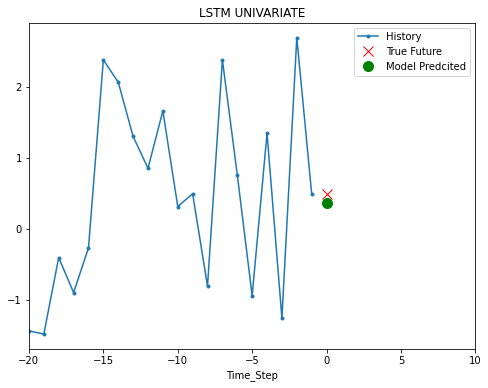

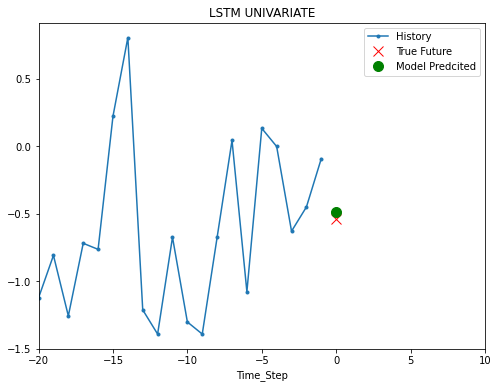

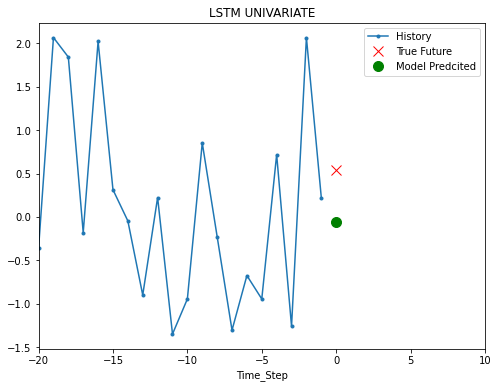

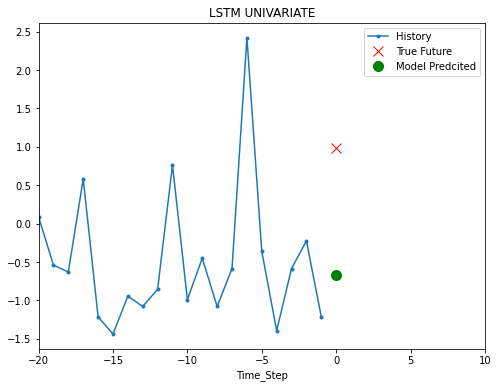

In [ ]:
for i , j in val_uni.take(5):
  plot = plot_time_series([i[0].numpy() , j[0].numpy() , lstm_model.predict(i)[0]] ,0 , 'LSTM UNIVARIATE')
  plot.show()

In [ ]:
features_3 = ['client_id', 'total', 'DayDiff']

features = df[features_3]
features.index = df['InvoiceDay']
features.head()


,client_id,total,DayDiff
InvoiceDay,,,
2013-05-18,29293,40.0,39.0
2013-06-25,29293,45.0,38.0
2013-08-11,29293,45.0,47.0
2013-10-17,29293,45.0,67.0
2013-12-03,29293,40.0,47.0


array([<AxesSubplot:xlabel='InvoiceDay'>,
       <AxesSubplot:xlabel='InvoiceDay'>,
       <AxesSubplot:xlabel='InvoiceDay'>], dtype=object)

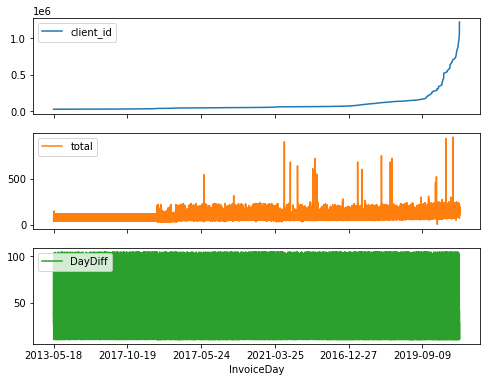

In [ ]:
features.plot(subplots=True)


In [ ]:
### standardize data
dataset = features.values

data_mean = dataset[:train_split].mean(axis =0)

data_std = dataset[:train_split].std(axis = 0)

dataset = (dataset - data_mean)/data_std

In [ ]:
### create mutlivariate data

def mutlivariate_data(dataset , target , start_idx , end_idx , history_size , target_size,
                      step ,  single_step = False):
  data = []
  labels = []
  start_idx = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx ):
    idxs = range(i-history_size, i, step) ### using step
    data.append(dataset[idxs])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data) , np.array(labels)


In [ ]:
### generate multivariate data

history = 720
future_target = 72
STEP = 6

x_train_ss , y_train_ss = mutlivariate_data(dataset , dataset[:, 1], 0, train_split, history,
                                            future_target, STEP , single_step = True)

x_val_ss , y_val_ss = mutlivariate_data(dataset , dataset[:,1] , train_split , None , history ,
                                        future_target, STEP, single_step = True)

print(x_train_ss.shape , y_train_ss.shape)

(264377, 120, 3) (264377,)


In [ ]:
## tensorflow dataset

train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))
val_ss = val_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_ss)
print(val_ss)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [ ]:
### Modelling using LSTM

single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(32, input_shape = x_train_ss.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mae')
single_step_model_history = single_step_model.fit(train_ss, epochs = EPOCHS , 
                                                  steps_per_epoch =steps, validation_data = val_ss,
                                                  validation_steps = 50)

Epoch 1/10
20/20 [==============================] - 21s 775ms/step - loss: 0.6768 - val_loss: 1.5404
Epoch 2/10
20/20 [==============================] - 11s 566ms/step - loss: 0.6523 - val_loss: 1.4910
Epoch 3/10
20/20 [==============================] - 12s 586ms/step - loss: 0.6672 - val_loss: 1.4915
Epoch 4/10
20/20 [==============================] - 11s 561ms/step - loss: 0.6663 - val_loss: 1.5037
Epoch 5/10
20/20 [==============================] - 11s 555ms/step - loss: 0.6614 - val_loss: 1.4887
Epoch 6/10
20/20 [==============================] - 14s 712ms/step - loss: 0.6911 - val_loss: 1.5353
Epoch 7/10
20/20 [==============================] - 13s 677ms/step - loss: 0.6746 - val_loss: 1.5019
Epoch 8/10
20/20 [==============================] - 11s 555ms/step - loss: 0.6947 - val_loss: 1.5018
Epoch 9/10
20/20 [==============================] - 12s 593ms/step - loss: 0.6763 - val_loss: 1.5197
Epoch 10/10
20/20 [==============================] - 12s 622ms/step - loss: 0.6960 - val_lo

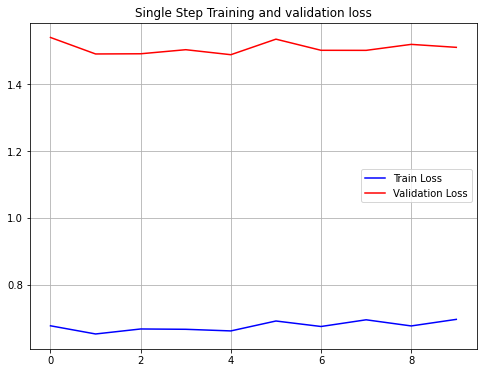

In [ ]:
## plot train test loss 

def plot_loss(history , title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train Loss')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()

plot_loss(single_step_model_history , 'Single Step Training and validation loss')

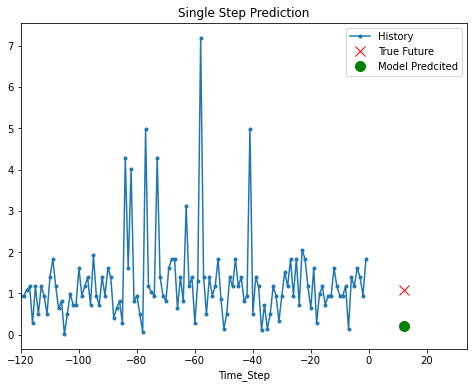

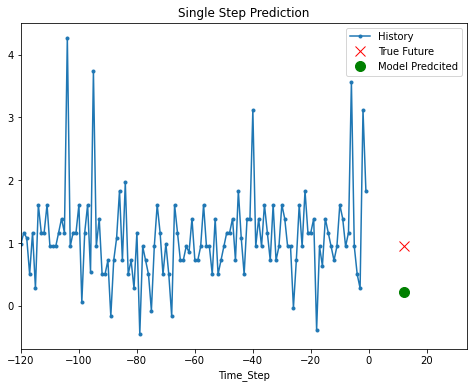

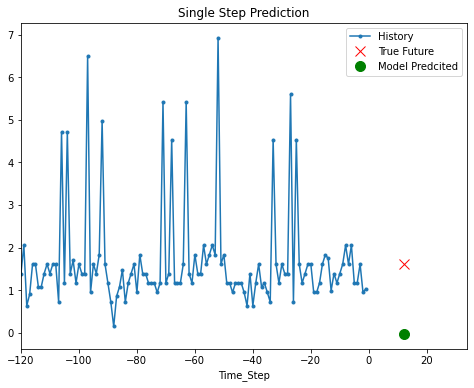

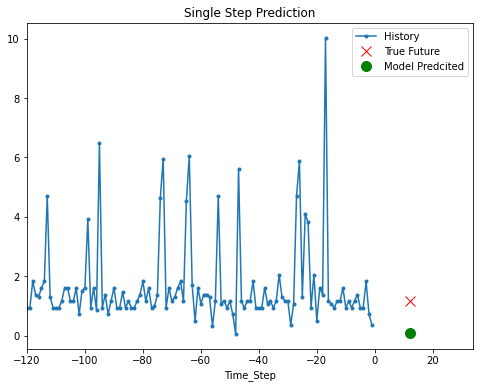

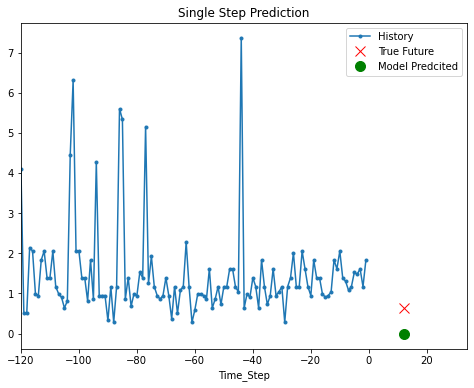

In [ ]:
# plot time series and predicted values

for x, y in val_ss.take(5):
  plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [ ]:
future_target = 72 # 72 future values
x_train_multi, y_train_multi = mutlivariate_data(dataset, dataset[:, 1], 0,
                                                 train_split, history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = mutlivariate_data(dataset, dataset[:, 1],
                                             train_split, None, history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

(264377, 120, 3)
(264377, 72)


In [ ]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

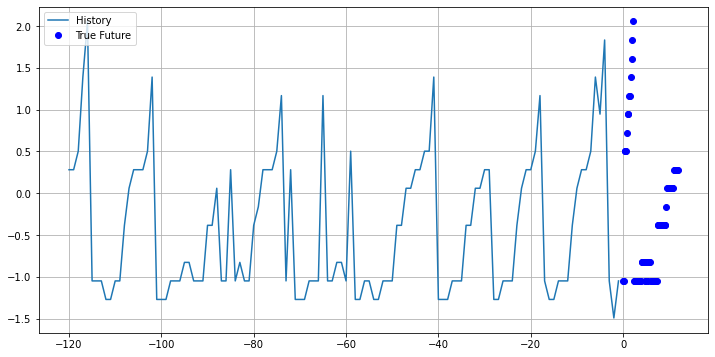

In [ ]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=steps,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
20/20 [==============================] - 25s 992ms/step - loss: 1.7572 - val_loss: 1.6256
Epoch 2/10
20/20 [==============================] - 17s 863ms/step - loss: 0.7251 - val_loss: 1.6443
Epoch 3/10
20/20 [==============================] - 22s 1s/step - loss: 0.7107 - val_loss: 1.6614
Epoch 4/10
20/20 [==============================] - 21s 1s/step - loss: 0.6890 - val_loss: 1.6709
Epoch 5/10
20/20 [==============================] - 17s 869ms/step - loss: 0.6977 - val_loss: 1.6814
Epoch 6/10
20/20 [==============================] - 23s 1s/step - loss: 0.6880 - val_loss: 1.6829
Epoch 7/10
20/20 [==============================] - 20s 1s/step - loss: 0.6767 - val_loss: 1.6902
Epoch 8/10
20/20 [==============================] - 19s 998ms/step - loss: 0.6879 - val_loss: 1.6869
Epoch 9/10
20/20 [==============================] - 23s 1s/step - loss: 0.6769 - val_loss: 1.6802
Epoch 10/10
20/20 [==============================] - 20s 993ms/step - loss: 0.6949 - val_loss: 1.6801


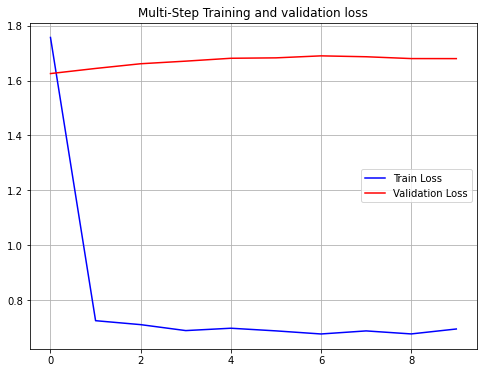

In [ ]:
plot_loss(multi_step_history, 'Multi-Step Training and validation loss')


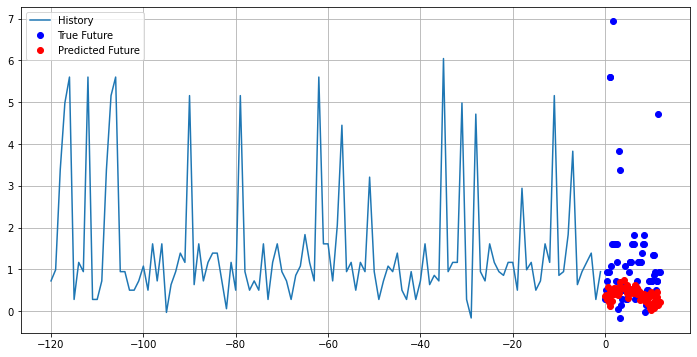

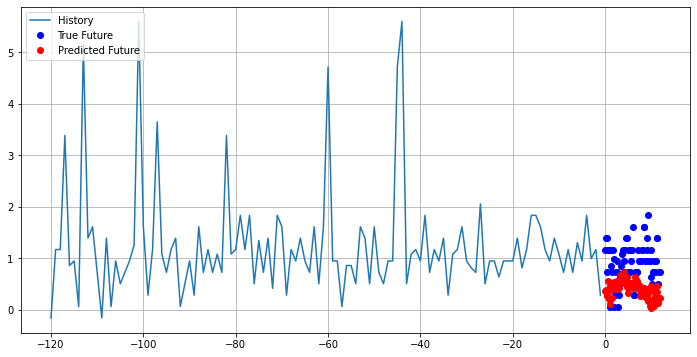

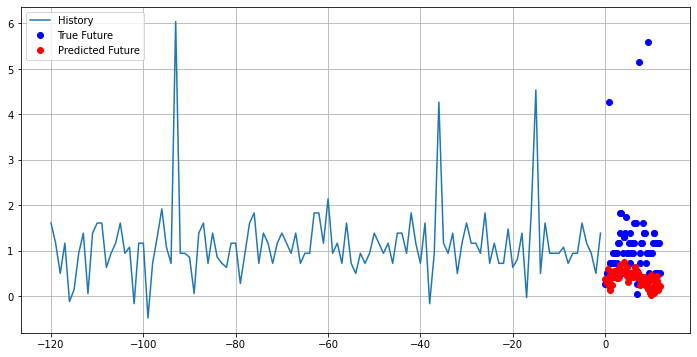

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
